# memo

１、Grad_camをクラス化し、自動で行えるようにする。
２、そのほかのモデルの解釈の仕方、説明可能性について検討する。
３、最新モデルのでの転移学習の実施
４、resnetの転移学習と手元データで１から学習したモデルに違いがあるかどうかの確認。


# データ記録

In [1]:
import torch
from torchvision import models
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import datetime
from torchvision.models import mobilenetv2
import cv2
# 自作モデルのインポート
import models.ore_no_zenketugou_model as zenketu
import models.train_loop as train_loop #訓練ループを格納
import class_name # ラベルの呼び出し

In [2]:
df = pd.read_csv('record.csv', index_col=0)
df

,id,architecture,karnel_size,batch_normalization,dropout,activation_fn,data_augmentation,optimizer,loss_fn,params_num(M),train_acc,val_acc,n_epochs,done
0,1,CNN,256,1,0.00,relu,拡大縮小、回転、反転、射影変換,SDG,CrossEntropyLoss,42.0,0.642100,0.441700,100,1.0
1,2,CNN,128,1,0.00,relu,拡大縮小、回転、反転、射影変換,SDG,CrossEntropyLoss,25.0,0.727953,0.437100,100,1.0
2,3,CNN,256,0,0.00,relu,拡大縮小、回転、反転、射影変換,SDG,CrossEntropyLoss,42.0,0.849992,0.370700,100,1.0
3,4,CNN,256,1,0.05,relu,拡大縮小、回転、反転、射影変換,SDG,CrossEntropyLoss,42.0,0.619680,0.438200,100,1.0
4,5,CNN,256,1,0.00,sigmoid,拡大縮小、回転、反転、射影変換,SDG,CrossEntropyLoss,42.0,0.022300,0.022800,100,1.0
5,6,全結合,0,1,0.01,relu,拡大縮小、回転、反転、射影変換,SDG,CrossEntropyLoss,38.0,0.469100,0.333700,100,1.0
6,7,CNN,256,1,0.00,relu,拡大縮小、回転、反転,SDG,CrossEntropyLoss,42.0,0.881260,0.435900,100,1.0
7,8,CNN,256,1,0.00,relu,なし,SDG,CrossEntropyLoss,42.0,0.881260,0.435900,100,1.0
8,9,CNN,256,1,0.00,relu,拡大縮小、回転、反転、射影変換,adam,CrossEntropyLoss,42.0,0.010003,0.010016,100,1.0
9,10,resnet3,256,1,0.00,relu,拡大縮小、回転、反転、射影変換,momentumSGD,CrossEntropyLoss,10.0,0.665293,0.347700,50,1.0


In [3]:
col = ['id', 'architecture', 'karnel_size', 'batch_normalization',
      'dropout','activation_fn', 'data_augmentation', 'optimizer',
       'loss_fn', 'params_num','train_acc', 'val_acc', 'n_epochs']
# df = pd.DataFrame([], columns=col)

# df2 = pd.DataFrame([[11,'resnet34_転移学習',256,1,
#                     0,'relu','拡大縮小、回転、反転、射影変換','adam',
#                     'CrossEntropyLoss',10,0.5,0.5,100]],columns=col)
# df2

In [6]:
# df = pd.concat([df,df2],axis=0)
# df

In [166]:
# df.to_csv('record.csv')

# データ・モデル準備

In [3]:
# cifar100を利用する
data_path = './cifar-100'
# 訓練データと検証データのダウンロード
tensor_cifar100_train = datasets.CIFAR100(data_path,
                                          train=True,
                                          download=True,
                                          transform=transforms.ToTensor())
tensor_cifar100_val = datasets.CIFAR100(data_path,
                                        train=False,
                                        download=True,
                                        transform=transforms.ToTensor())

# ラベルを取得
class_names = class_name.class_names()
super_class_names = class_name.super_class_names()

# テンソルを束ねる
imgs = torch.stack([img_t for img_t, _ in tensor_cifar100_train], dim = 3)

# RGB各々の平均、標準偏差を計算する
means = imgs.view(3,-1).mean(dim=1)
stds = imgs.view(3,-1).std(dim=1)

# 各画像データを標準化する
transformed_tensor_cifar100_train = datasets.CIFAR100(data_path,
                                                      train=True,
                                                      download=False,
                                                      transform=transforms.Compose([
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(means,stds),
                                                          transforms.RandomResizedCrop(size=32, scale=(0.8,1.0)), #データの拡大縮小及びアスペクト比の変更
                                                          transforms.RandomHorizontalFlip(p=0.3), # 画像をp％の確率で左右反転させる
                                                          transforms.RandomVerticalFlip(p=0.3), # 画像をp％の確率で上下反転させる
                                                          transforms.RandomRotation(degrees=(-89,89)), #-89~89度の間で回転させる
                                                          # transforms.RandomPerspective(distortion_scale=0.2,p=0.3) #画像を確率pで射影変換する
                                                      ]))
transformed_tensor_cifar100_val = datasets.CIFAR100(data_path,
                                                   train=False,
                                                   download=False,
                                                   transform = transforms.Compose([
                                                       transforms.ToTensor(),
                                                       transforms.Normalize(means,stds)
                                                   ]))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# パラメータの設定
# データローダーに入れることで、簡単にデータを取り扱う
batch_size = 1000
# train_loader = torch.utils.data.DataLoader(
#     transformed_tensor_cifar100_train,
#     batch_size=batch_size,
#     shuffle=False)
val_loader = torch.utils.data.DataLoader(
    transformed_tensor_cifar100_val,
    batch_size=batch_size,
    shuffle=False)
# 学習率の設定
# learning_rate = 1e-2
# # パラメータの修正に確率的勾配降下方を利用
# optimizer = optim.SGD(model.parameters(), lr = learning_rate)
# # 損失関数を定義
# loss_fn = nn.CrossEntropyLoss()
# # エポック数を設定
# n_epochs = 1

In [5]:
# モデルの呼び出し
d_path = './para_models/'
loaded_model = zenketu.CNNBatchNorm_ReLU(n_chans1=256)
loaded_model.load_state_dict(torch.load(d_path + 'CNN256_BatchNorm_Relu.pt'))

<All keys matched successfully>

In [6]:
loaded_model.eval()

CNNBatchNorm_ReLU(
  (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=100, bias=True)
)

In [7]:
for i in val_loader:
    img,labels = i

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
oranges
woman


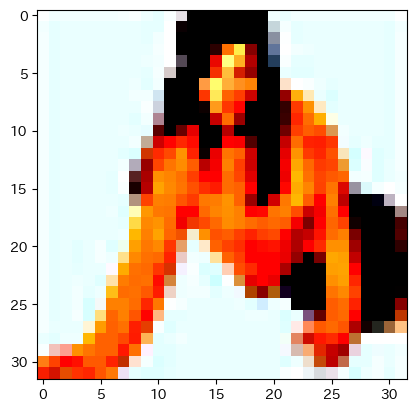

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
tiger
tiger


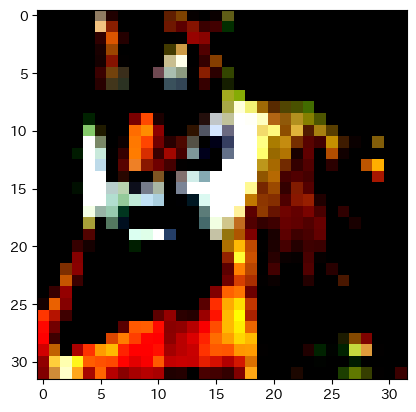

In [8]:
for i in range(1,3):
    num = i
    print(i)
    print(class_names[torch.argmax(loaded_model(img[num].unsqueeze(0))).item()])
    print(class_names[labels[num].item()])
    plt.imshow(img[num].permute(1,2,0))
    plt.show()

# Grad_CAM

In [80]:
class GradCAM:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        # 最終層逆伝播時の勾配を記録する
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        # 最終層の出力 Feature Map を記録する
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self, output, target):
        self.model.zero_grad()
        one_hot_output = torch.zeros([1, output.size()[-1]])
        one_hot_output[0][target] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()

In [326]:
def grad_try(nums):
    for i in nums:
        grad_cam = GradCAM(model = loaded_model, feature_layer=loaded_model.conv2_batchnorm)
        num = i
        img_n = img[num].unsqueeze(0)
        model_output = grad_cam.forward(img_n)
        target = model_output.argmax(1).item()

        grad_cam.backward_on_target(model_output, target)

        # Get feature gradient
        feature_grad = grad_cam.feature_grad.data.numpy()[0]
        # Get weights from gradient
        weights = np.mean(feature_grad, axis=(1, 2))  # Take averages for each gradient
        # Get features outputs
        feature_map = grad_cam.feature_map.data.numpy()
        grad_cam.clear_hook()
        VISUALIZE_SIZE = (32, 32)

        # Get cam
        cam = np.sum((weights * feature_map.T), axis=2).T
        cam = np.maximum(cam, 0)  # apply ReLU to cam
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = cv2.resize(cam, VISUALIZE_SIZE)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize

        # ヒートマップの作成
        activation_heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
        activation_heatmap = cv2.cvtColor(activation_heatmap, cv2.COLOR_BGR2RGB)  #色反転

        # 元画像をplt下でも使えるように変換
        img_n2 = img_n.permute(2,3,1,0).squeeze(3).numpy()

        # 画像を合成する
        img_with_heatmap = np.multiply(np.float32(activation_heatmap), np.float32(img_n2)) #画像の形態を合わせて合成
        img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)

        print('画像番号:',i,'モデルが推定した答え：', class_names[torch.argmax(loaded_model(img[num].unsqueeze(0))).item()])
        print('答え', class_names[labels[num].item()])
        plt.figure(figsize=(21,7))
        plt.subplot(1,3,1)
        plt.imshow(img_n2)
        plt.subplot(1,3,2)
        plt.imshow(activation_heatmap) # 合成前のヒートマップを確認したい場合有効にする。
        plt.subplot(1,3,3)
        plt.imshow(img_with_heatmap)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


画像番号: 0 モデルが推定した答え： lamp
答え cups


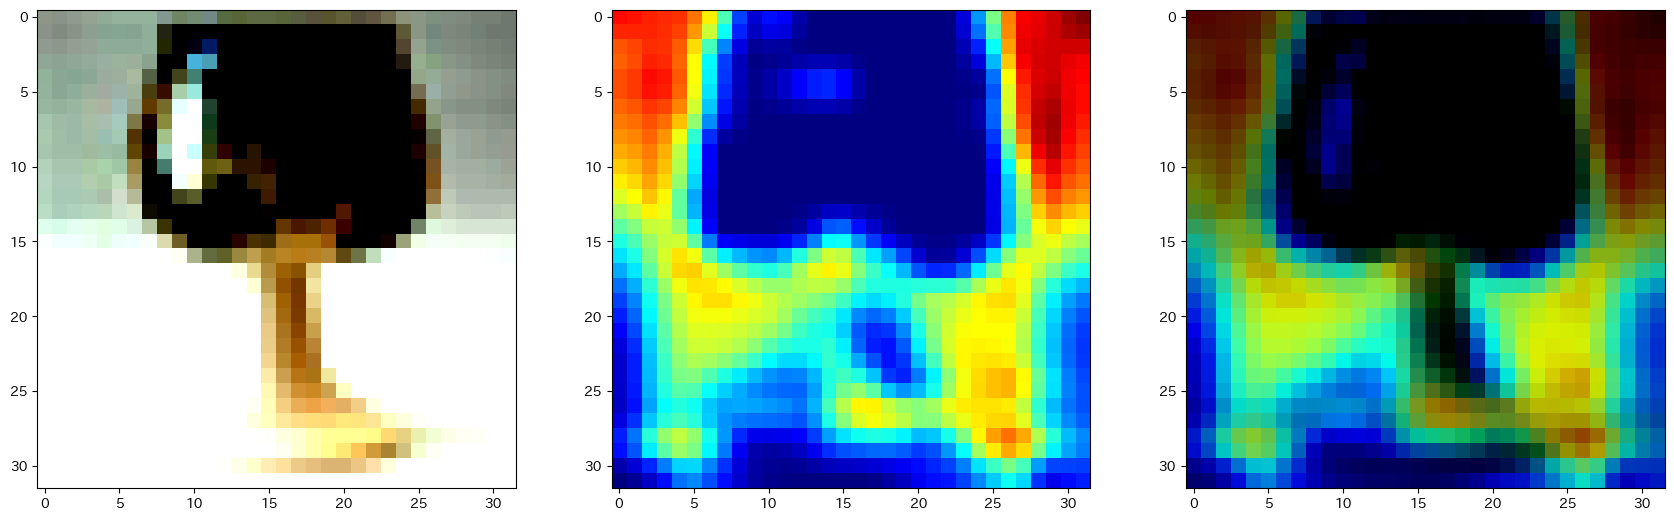

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


画像番号: 2 モデルが推定した答え： tiger
答え tiger


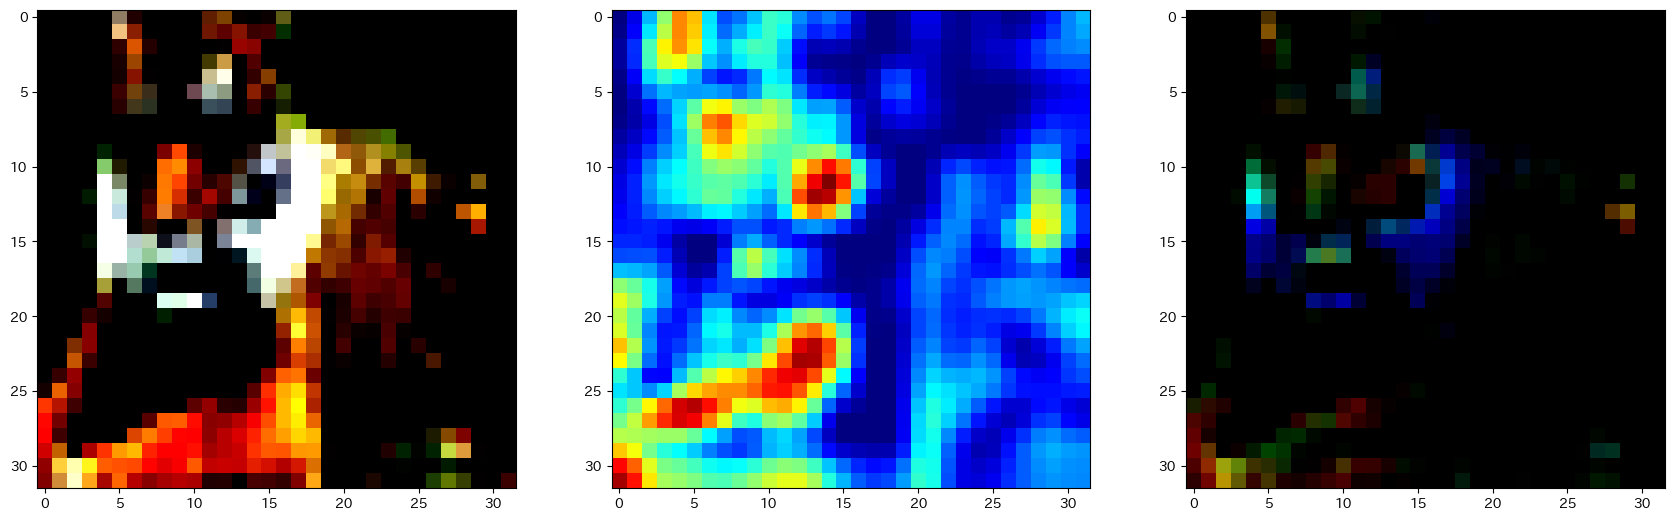

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


画像番号: 4 モデルが推定した答え： crab
答え bear


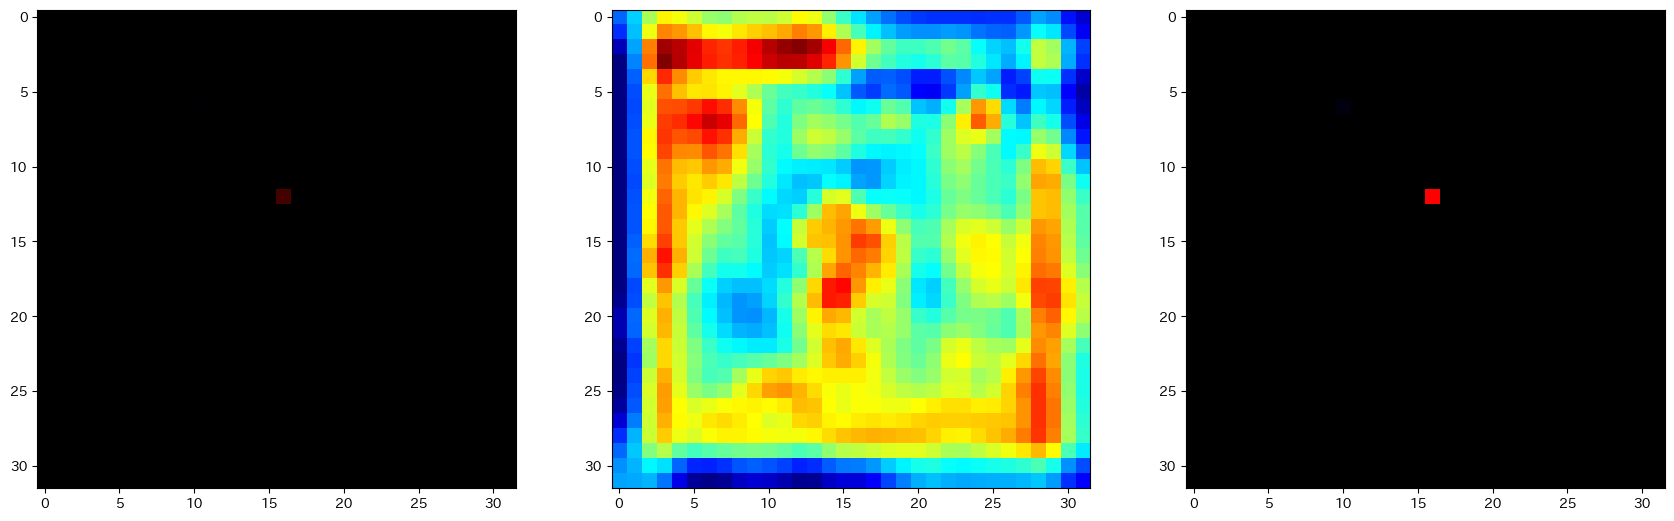

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


画像番号: 6 モデルが推定した答え： road
答え plain


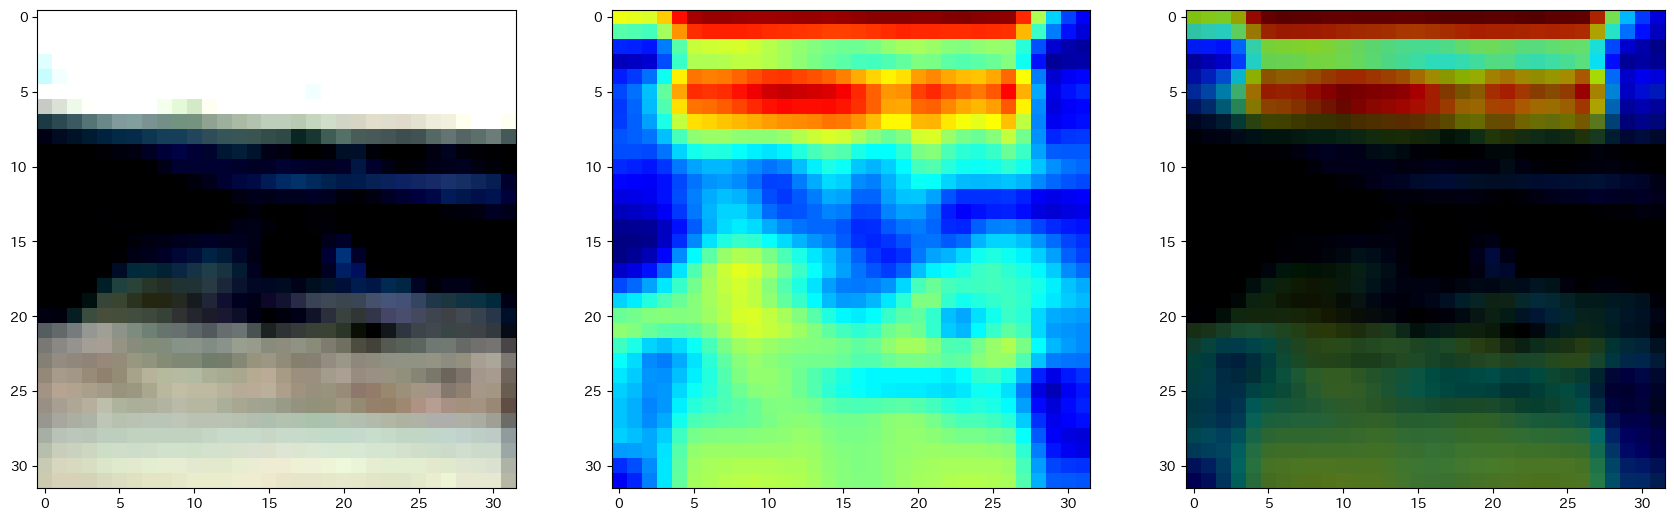

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


画像番号: 8 モデルが推定した答え： lizard
答え rocket


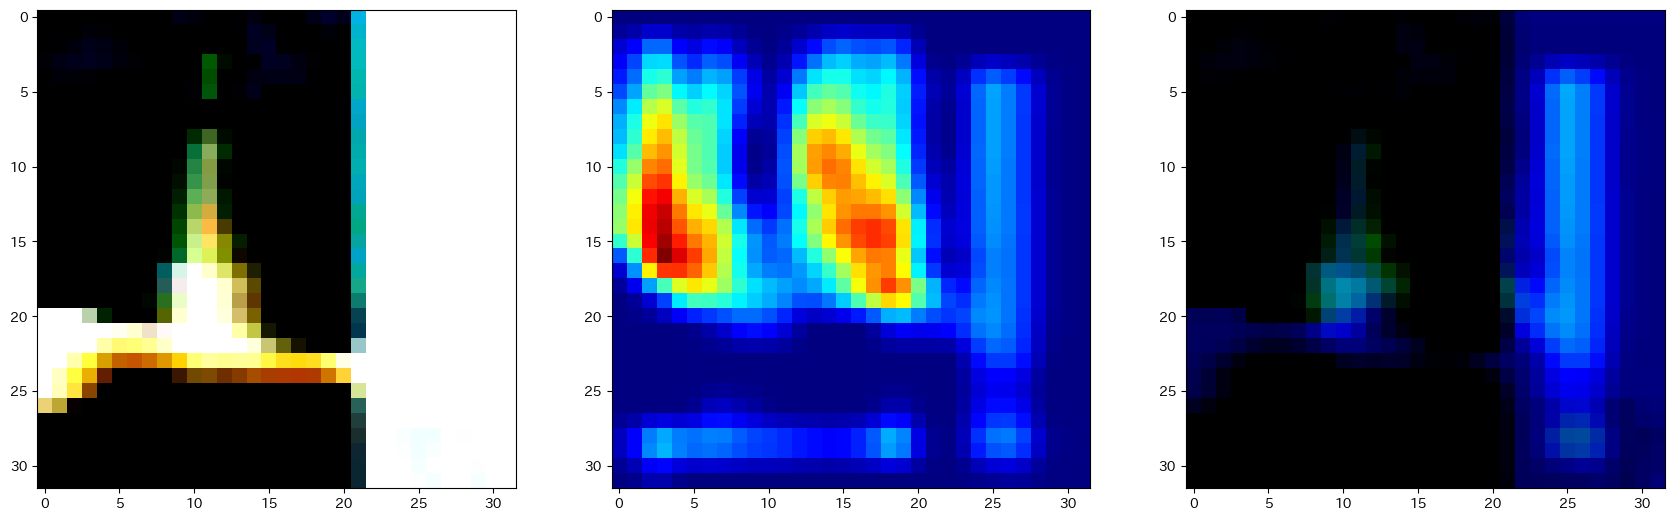

In [327]:
grad_try(range(0,10,2))